In [ ]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")


In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import mlflow
from mlflow.models import infer_signature

file_path = 'C:/Users/HUAWEI/Desktop/АиММО/Tesla.csv'
df = pd.read_csv(file_path)

def preprocess_tesla_data(df):
    df = df.dropna()
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.drop(columns=['Adj Close'])
    X = df.drop(columns=['Close'])
    y = df['Close']
    return X, y

# масштабируем данные
def scale_features(X, y):
    scaler = StandardScaler()
    power_trans = PowerTransformer()
    X_scaled = scaler.fit_transform(X.drop(columns=['Date']).values)
    y_scaled = power_trans.fit_transform(y.values.reshape(-1, 1))
    return X_scaled, y_scaled, power_trans

# оценка метрик
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

X, y = preprocess_tesla_data(df)
X_scaled, y_scaled, power_trans = scale_features(X, y)

# разбиваем на тестовую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42)

# опред гиперпараметров для SGDRegressor
params = {
    'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1],
    'l1_ratio': [0.001, 0.05, 0.01, 0.2],
    'penalty': ['l1', 'l2', 'elasticnet'],
}

# обучение модели SGDRegressor с GridSearchCV
lr = SGDRegressor(random_state=42)
clf = GridSearchCV(lr, params, cv=5)
clf.fit(X_train, y_train.ravel())
best_model = clf.best_estimator_

# предсказание на валидационной выборке
y_pred = best_model.predict(X_val)
y_price_pred = power_trans.inverse_transform(y_pred.reshape(-1, 1))

# оценка метрик
rmse, mae, r2 = eval_metrics(power_trans.inverse_transform(y_val), y_price_pred)

# логирование
with mlflow.start_run():
    mlflow.log_param("alpha", best_model.alpha)
    mlflow.log_param("l1_ratio", best_model.l1_ratio)
    mlflow.log_param("penalty", best_model.penalty)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2", r2)
    signature = infer_signature(X_train, best_model.predict(X_train))
    mlflow.sklearn.log_model(best_model, "model", signature=signature, input_example=X_train[:5])
# сравниваем с другими моделями
models = {
    "RandomForestRegressor": RandomForestRegressor(random_state=42),
    "XGBRegressor": XGBRegressor(random_state=42, eval_metric='rmse')
}

for name, model in models.items():
    with mlflow.start_run(run_name=name):
        model.fit(X_train, y_train.ravel())
        y_pred = model.predict(X_val)
        y_price_pred = power_trans.inverse_transform(y_pred.reshape(-1, 1))
        rmse, mae, r2 = eval_metrics(power_trans.inverse_transform(y_val), y_price_pred)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("r2", r2)
        mlflow.sklearn.log_model(model, "model", input_example=X_train[:5])
        print(f"Model: {name}")
        print(f"RMSE: {rmse}, MAE: {mae}, R2: {r2}\n")

rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

rf_model = RandomForestRegressor(random_state=42)
rf_grid = GridSearchCV(rf_model, rf_params, cv=5)
rf_grid.fit(X_train, y_train.ravel())
best_rf_model = rf_grid.best_estimator_

# оценка лучшей модели RandomForestRegressor
with mlflow.start_run(run_name="Best_RandomForestRegressor"):
    y_pred = best_rf_model.predict(X_val)
    y_price_pred = power_trans.inverse_transform(y_pred.reshape(-1, 1))
    rmse, mae, r2 = eval_metrics(power_trans.inverse_transform(y_val), y_price_pred)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2", r2)
    mlflow.sklearn.log_model(best_rf_model, "model", input_example=X_train[:5])
    print(f"Best RandomForestRegressor - RMSE: {rmse}, MAE: {mae}, R2: {r2}")


🏃 View run persistent-dove-165 at: http://127.0.0.1:5000/#/experiments/0/runs/ade492adc556440fbfe0d0e508abc242
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


Model: RandomForestRegressor
RMSE: 2.197313749070595, MAE: 1.378368358064349, R2: 0.9994568152029927

🏃 View run RandomForestRegressor at: http://127.0.0.1:5000/#/experiments/0/runs/1af0bd6a1ccd41a8bfab1c70e3fccb48
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


Model: XGBRegressor
RMSE: 2.3708667191173003, MAE: 1.4809213238590258, R2: 0.9993676205618424

🏃 View run XGBRegressor at: http://127.0.0.1:5000/#/experiments/0/runs/393931391f304b2f86081526b609cb15
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


Best RandomForestRegressor - RMSE: 2.1806966846012847, MAE: 1.3622976733017935, R2: 0.9994649997482928
🏃 View run Best_RandomForestRegressor at: http://127.0.0.1:5000/#/experiments/0/runs/11763c7fb9664c4bba0b9dd9273e48e7
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


In [17]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

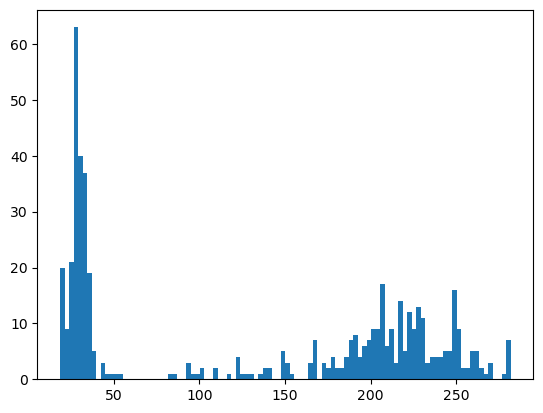

In [20]:
import joblib
joblib_file = "C:/Users/HUAWEI/mlartifacts/0/1af0bd6a1ccd41a8bfab1c70e3fccb48/artifacts/model/model.pkl"
joblib_model = joblib.load(joblib_file)
y = power_trans.inverse_transform(joblib_model.predict(X_val).reshape(-1, 1))
plt.hist(y, 100);

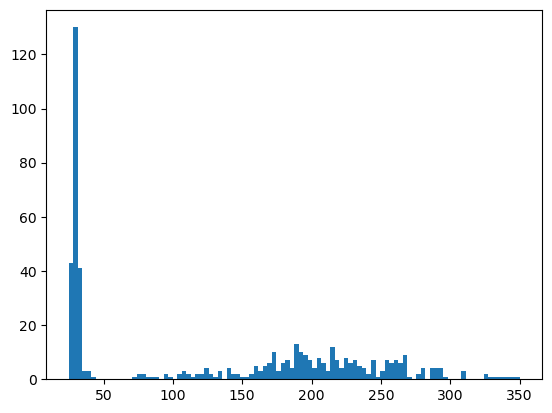

In [21]:
import joblib
joblib_file = "C:/Users/HUAWEI/mlartifacts/0/9f29d90ba809476d8437521b904bbb87/artifacts/model/model.pkl"
joblib_model = joblib.load(joblib_file)
y = power_trans.inverse_transform(joblib_model.predict(X_val).reshape(-1, 1))
plt.hist(y, 100);

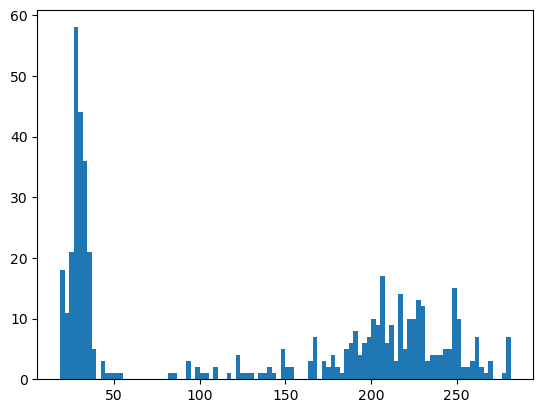

In [22]:
import joblib
joblib_file = "C:/Users/HUAWEI/mlartifacts/0/11763c7fb9664c4bba0b9dd9273e48e7/artifacts/model/model.pkl"
joblib_model = joblib.load(joblib_file)
y = power_trans.inverse_transform(joblib_model.predict(X_val).reshape(-1, 1))
plt.hist(y, 100);

In [ ]:
# Best_RandomForestRegressor показывает наилучшие результаты по всем метрикам 
# это значит то, что модель имеет наименьшую ошибку предсказания и лучше всего объясняет дисперсию данных